**STAT 301 Report: Predicting the working hours per week** <br>
**Group 5** : Hannah Ban, Christine Sun, Eric Tang, Luqi Tang

**Introduction**

Existing academic scholarship attempts to account for the factors that predict adult income. A book by Messenger et al. (2007) addresses working time, including national trends in working hours among different countries. Chapter 4 examines the relationship between working hours and various age and gender cohorts. Their conclusion that age and gender are associated with working hours is illustrated through an international “gender gap” and a general reduction in working hours for individuals over 65 (Messenger et al., 2007). Similarly, a regression analysis conducted by Dunga (2017) based on a low-income, South African township concludes that marital status correlates with household income levels. <br>
	From a sociological perspective, Clawson and Gerstel (2014) examine the ways that gender, class, and familial interactions affect workers’ working hours and their responses to unpredictable events that impact their work. They noted that gender plays a significant role inside and outside of the workplace—especially pertaining to resolving unpredictable circumstances and allocating work hours, while different socioeconomic classes exert varying degrees of control over their hours (Clawson & Gerstel, 2014). <br>
	Having deliberated previous literature surrounding adult income, it is relevant to examine the possibility of projecting working hours based on multiple factors. We will analyse data collected in 1994 by Ronny Kohavi and Barry Becker for the United States Census Bureau database. The dataset represents a set of reasonable records where all observed individuals are older than 16 with an income greater than $100, working more than 0 hours per week, and each observed individual is representative of more than a single American adult. Based on the preliminary plots, we will use 6 explanatory variables: age, income, marital status, sex, workclass and occupation, to predict the response variable of the number of hours worked per week. <br>
* Age: age of the individual
* Income: grouped by '>50k' and '<50k'
* Marital Status: grouped by 'married' and 'not married'
* Sex: grouped by 'female' and 'male'
* Workclass: the work classification of the individual consisting of 7 levels
* Occupation: the occupation classification of the individual consisting of 14 levels

> The following is the link of data set: https://www.kaggle.com/datasets/uciml/adult-census-income

**Methods and Results**

In [28]:
library(tidyverse)
library(dplyr)
library(repr)
library(digest)
library(infer)
library(broom)
library(leaps)
library(GGally)
library(mltools)
library(glmnet)
library(faraway)
library(moments)

In [29]:
#reading the data
raw_adult_df<-read_csv("https://raw.githubusercontent.com/NingWang0123/stat201_project/main/adult.csv")

Rows: 32561 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): workclass, education, marital.status, occupation, relationship, rac...
dbl (6): age, fnlwgt, education.num, capital.gain, capital.loss, hours.per.week

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [30]:
#viewing the data
head(raw_adult_df)
nrow(raw_adult_df)
any(is.na(raw_adult_df))

age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K


[1] 32561

[1] FALSE

In [31]:
#cleaning the data and removing the "?" observations
noques_adult <- raw_adult_df %>% filter(!grepl("\\?", workclass))
noques_adult <- noques_adult %>% filter(!grepl("\\?", education))
noques_adult <- noques_adult %>% filter(!grepl("\\?", marital.status))
noques_adult <- noques_adult %>% filter(!grepl("\\?", occupation))
noques_adult <- noques_adult %>% filter(!grepl("\\?", relationship))
noques_adult <- noques_adult %>% filter(!grepl("\\?", race))
noques_adult <- noques_adult %>% filter(!grepl("\\?", sex))
noques_adult <- noques_adult %>% filter(!grepl("\\?", native.country))
noques_adult <- noques_adult %>% filter(!grepl("\\?", income))
noques_adult$workclass <- as.factor(noques_adult$workclass)
noques_adult$education <- as.factor(noques_adult$education)
noques_adult$marital.status <- as.factor(noques_adult$marital.status)
noques_adult$occupation <- as.factor(noques_adult$occupation)
noques_adult$relationship <- as.factor(noques_adult$relationship)
noques_adult$race <- as.factor(noques_adult$race)
noques_adult$sex <- as.factor(noques_adult$sex)
noques_adult$native.country <- as.factor(noques_adult$native.country)
noques_adult$income <- as.factor(noques_adult$income)

While cleaning the data, we removed 2 399 rows. Now we will examine the categorical variables and determine if any require grouping for ease of use (to ensure that training and testing doesn't encounter variables left unaccounted for).

In [32]:
noques_adult %>% count(education)

education,n
<fct>,<int>
10th,820
11th,1048
12th,377
1st-4th,151
5th-6th,288
7th-8th,557
9th,455
Assoc-acdm,1008
Assoc-voc,1307


In [33]:
noques_adult <- noques_adult %>% mutate(education = case_when(education.num < 3 ~ "-Elementary",
                        education.num >= 3 & education.num < 8 ~ "-HighSchool",
                                                             education.num >= 8 & education.num < 10 ~ "=HighSchool",
                                                             education.num >= 10 & education.num < 14 ~ "LowUpper",
                                                             education.num >= 14 ~ "HighUpper"))
noques_adult$education <- as.factor(noques_adult$education)
noques_adult <- noques_adult %>% select(-education.num)
noques_adult$marital.status <- ifelse((noques_adult$marital.status == "Widowed" | 
                                       noques_adult$marital.status == "Divorced" | 
                                       noques_adult$marital.status == "Separated" | 
                                       noques_adult$marital.status == "Never-Married"), "Not Married", "Married")
noques_adult$marital.status <- as.factor(noques_adult$marital.status)



In [34]:
noques_adult %>% count(native.country)
noques_adult %>% count(education)

native.country,n
<fct>,<int>
Cambodia,18
Canada,107
China,68
Columbia,56
Cuba,92
Dominican-Republic,67
Ecuador,27
El-Salvador,100
England,86


education,n
<fct>,<int>
-Elementary,196
-HighSchool,3168
=HighSchool,10217
HighUpper,2544
LowUpper,14037


We notice from the counted categories above that United-States dominates all other categories. It is most reasonable thus to group all other categories into an "Other" category.

In [35]:
noques_adult <- noques_adult %>% mutate(native.country = ifelse(native.country == "United-States", "United-States", "Other"))
noques_adult$native.country <- as.factor(noques_adult$native.country)

In [36]:
country_check <- noques_adult[!duplicated(noques_adult$native.country),] %>% select(native.country)
country_check

native.country
<fct>
United-States
Other


In [37]:
nrow(noques_adult %>% filter(workclass == "Without-pay"))

[1] 14

In [38]:
#filtered out the "Without-pay" observations because there was only 14 observations and they don't reasonably fit into any group
#so they were irrelevant
noques_adult <- noques_adult %>% filter(workclass != "Without-pay")
nrow(noques_adult %>% filter(workclass == "Without-pay"))

[1] 0

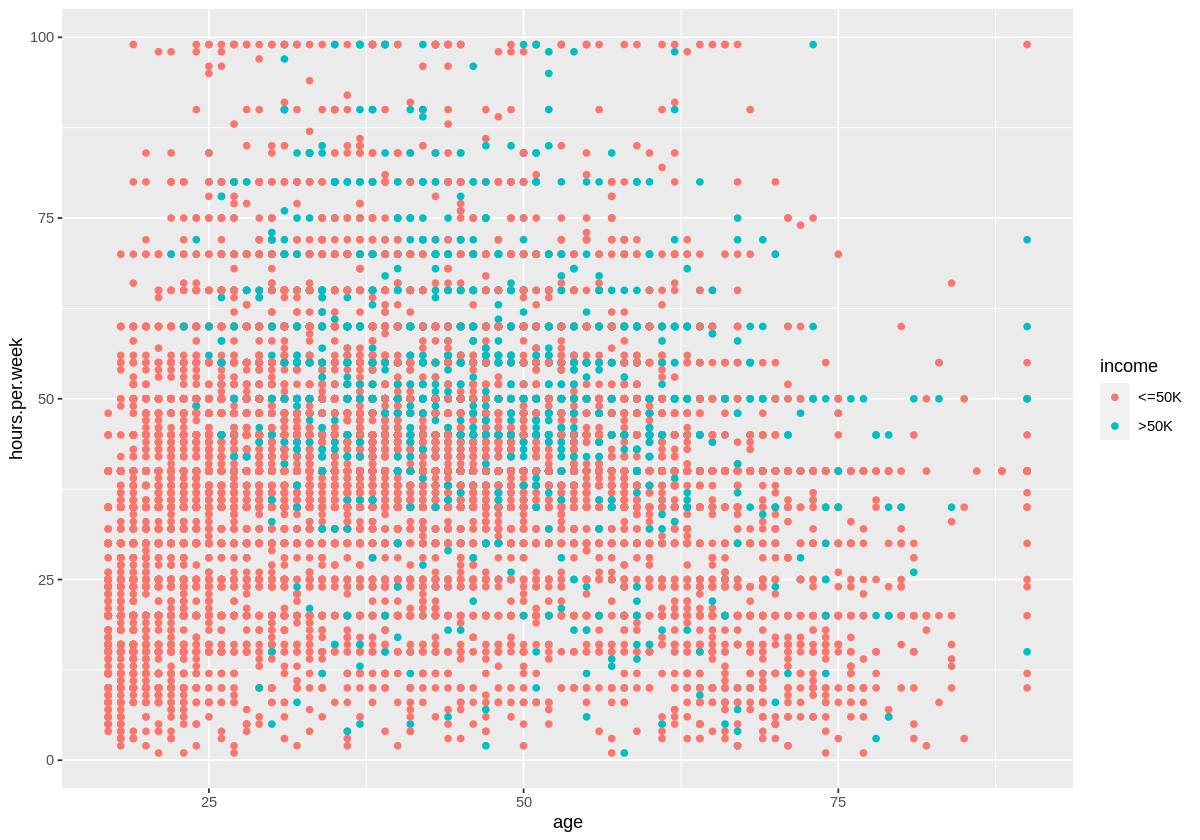

In [39]:
options(repr.plot.width = 10, repr.plot.height = 7)
hours_age_income_plot <- noques_adult %>% ggplot(aes(x = age, y = hours.per.week)) + geom_point(aes(colour = income))
hours_age_income_plot

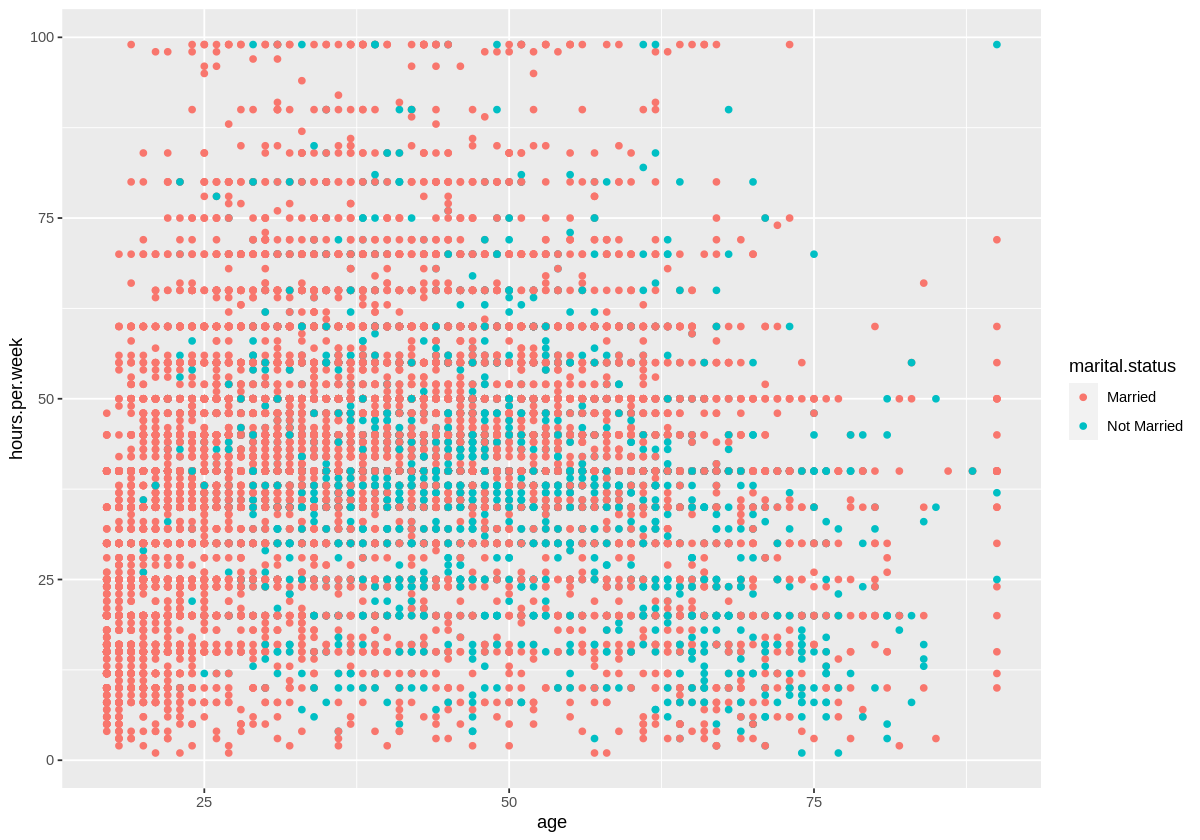

In [40]:
options(repr.plot.width = 10, repr.plot.height = 7)
hours_age_marital_plot <- noques_adult %>% ggplot(aes(x = age, y = hours.per.week)) + geom_point(aes(colour = marital.status))
hours_age_marital_plot

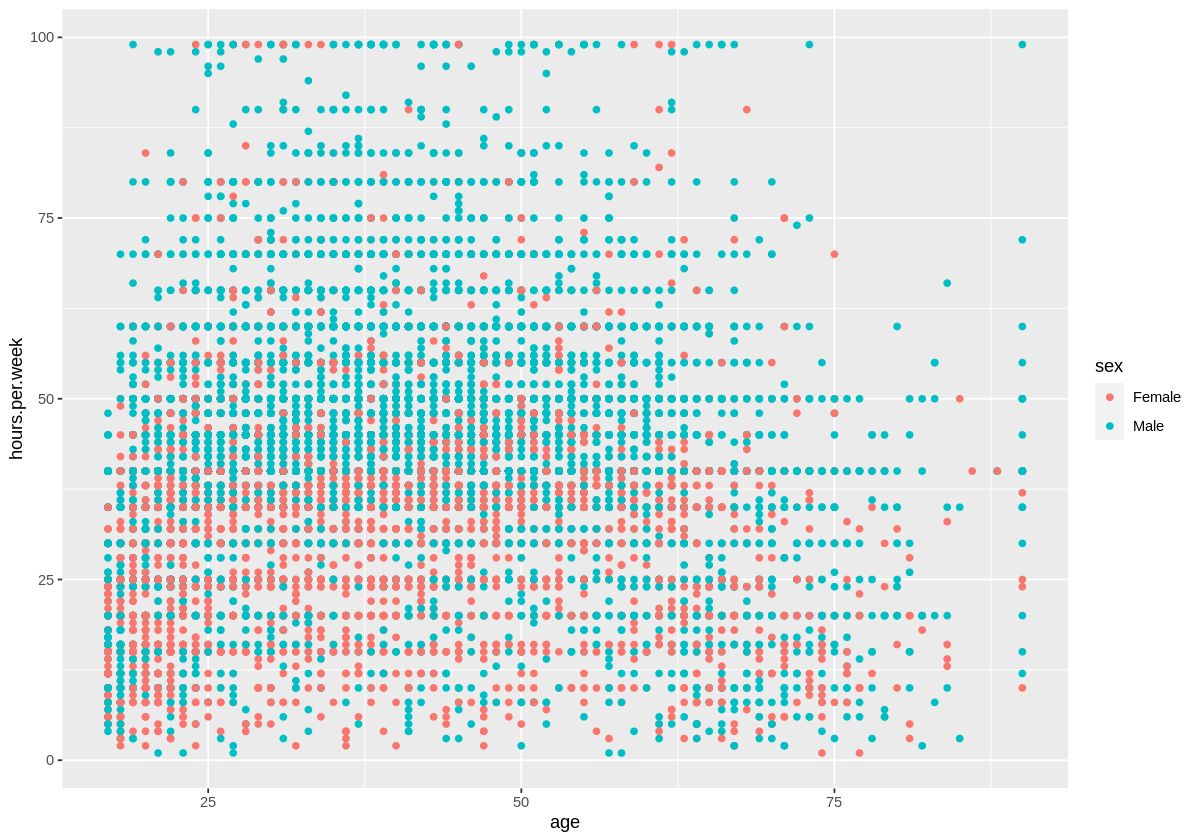

In [41]:
options(repr.plot.width = 10, repr.plot.height = 7)
hours_age_sex_plot <- noques_adult %>% ggplot(aes(x = age, y = hours.per.week)) + geom_point(aes(colour = sex))
hours_age_sex_plot

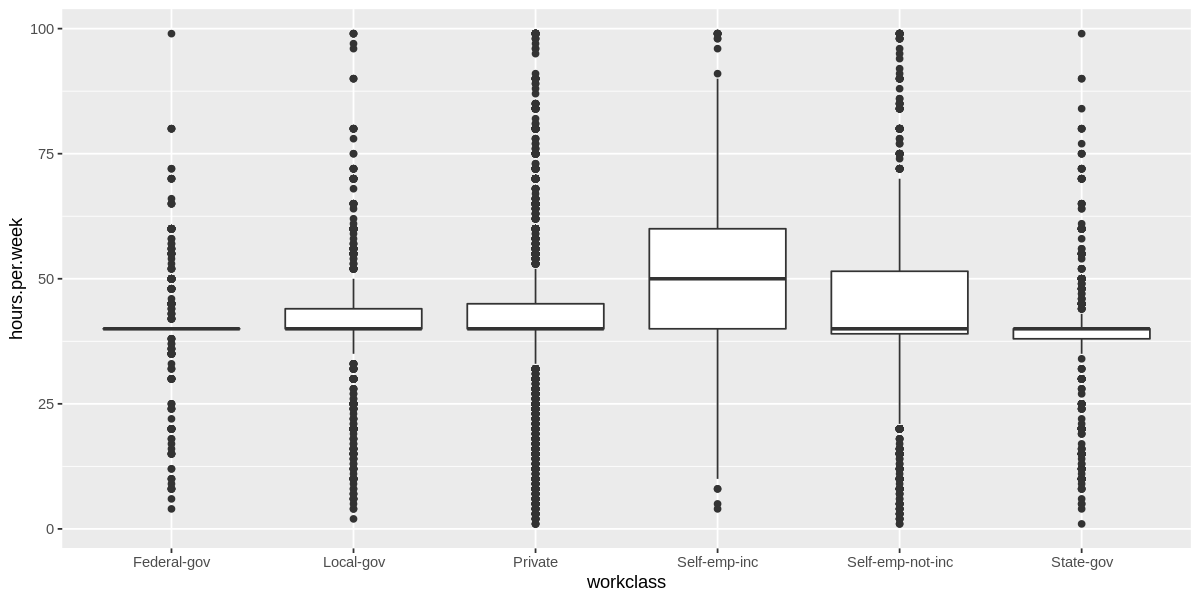

In [42]:
options(repr.plot.width = 10, repr.plot.height = 5)
hours_class_plot <- noques_adult %>% ggplot(aes(x = workclass, y = hours.per.week)) + geom_boxplot()
hours_class_plot

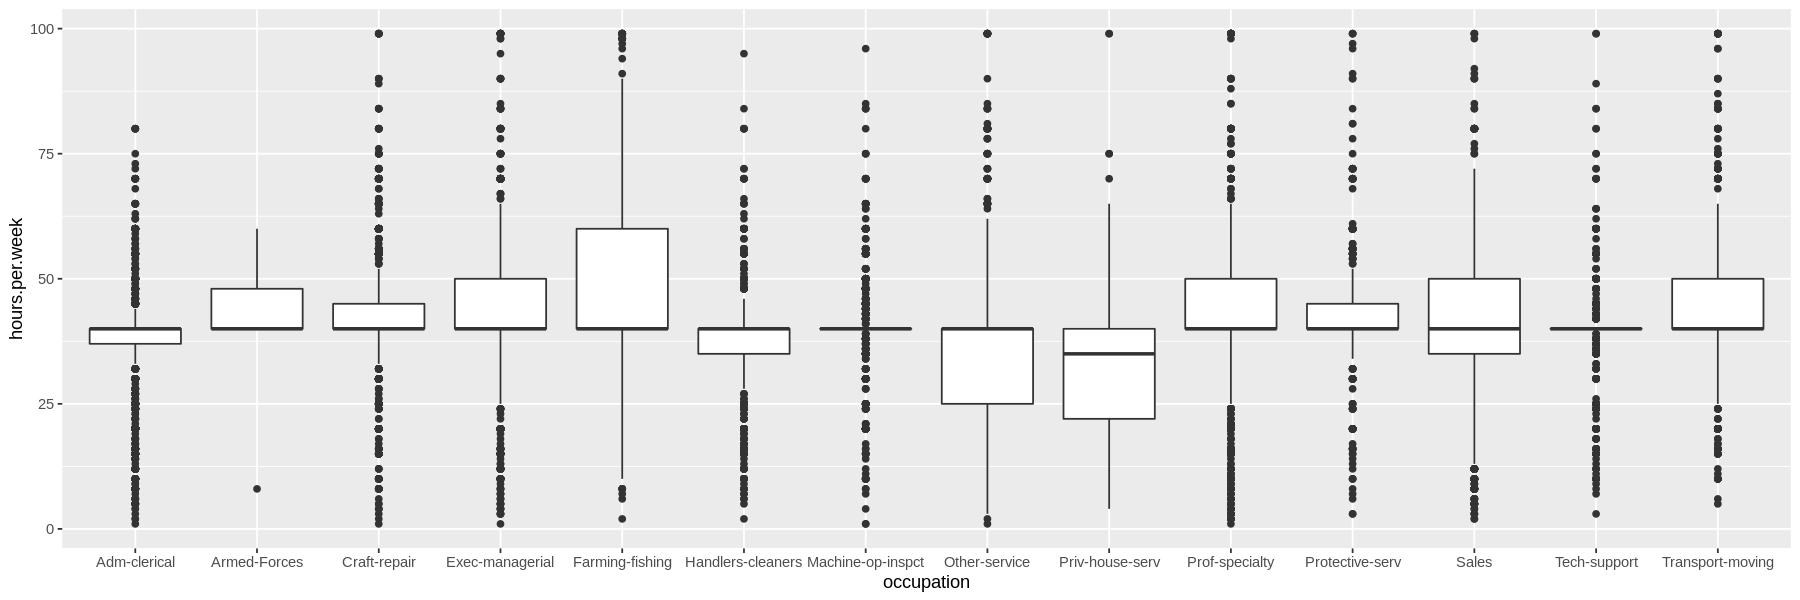

In [43]:
options(repr.plot.width = 15, repr.plot.height = 5)
hours_occupation_plot <- noques_adult %>% ggplot(aes(x = occupation, y = hours.per.week)) + geom_boxplot()
hours_occupation_plot

age,workclass,fnlwgt,education,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
82,Private,132870,=HighSchool,Not Married,Exec-managerial,Not-in-family,White,Female,0,4356,2.890372,United-States,<=50K
54,Private,140359,-HighSchool,Not Married,Machine-op-inspct,Unmarried,White,Female,0,3900,3.688879,United-States,<=50K
41,Private,264663,LowUpper,Not Married,Prof-specialty,Own-child,White,Female,0,3900,3.688879,United-States,<=50K
34,Private,216864,=HighSchool,Not Married,Other-service,Unmarried,White,Female,0,3770,3.806662,United-States,<=50K
38,Private,150601,-HighSchool,Not Married,Adm-clerical,Unmarried,White,Male,0,3770,3.688879,United-States,<=50K
74,State-gov,88638,HighUpper,Married,Prof-specialty,Other-relative,White,Female,0,3683,2.995732,United-States,>50K


age,workclass,fnlwgt,education,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
82,Private,132870,=HighSchool,Not Married,Exec-managerial,Not-in-family,White,Female,0,4356,4.242641,United-States,<=50K
54,Private,140359,-HighSchool,Not Married,Machine-op-inspct,Unmarried,White,Female,0,3900,6.324555,United-States,<=50K
41,Private,264663,LowUpper,Not Married,Prof-specialty,Own-child,White,Female,0,3900,6.324555,United-States,<=50K
34,Private,216864,=HighSchool,Not Married,Other-service,Unmarried,White,Female,0,3770,6.708204,United-States,<=50K
38,Private,150601,-HighSchool,Not Married,Adm-clerical,Unmarried,White,Male,0,3770,6.324555,United-States,<=50K
74,State-gov,88638,HighUpper,Married,Prof-specialty,Other-relative,White,Female,0,3683,4.472136,United-States,>50K


hours.per.week 
     0.3319005

hours.per.week 
     -2.410806

hours.per.week 
     -0.851369

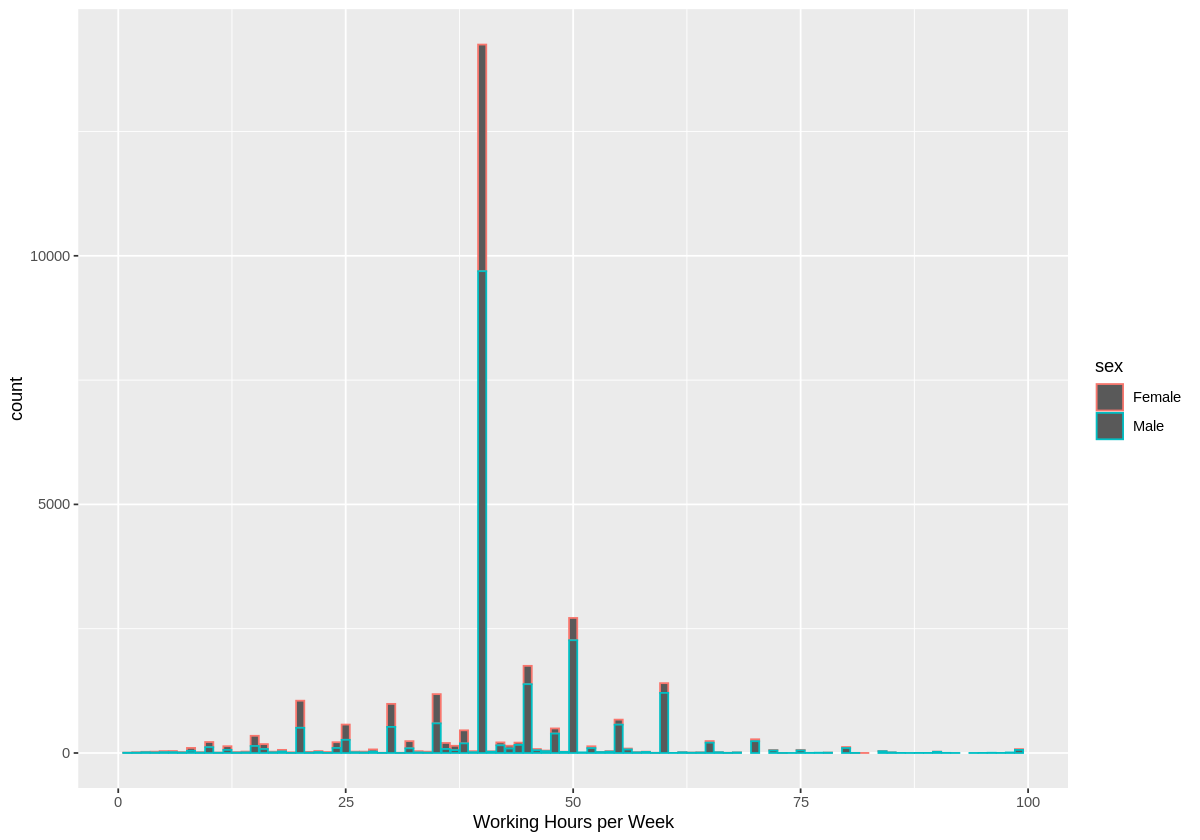

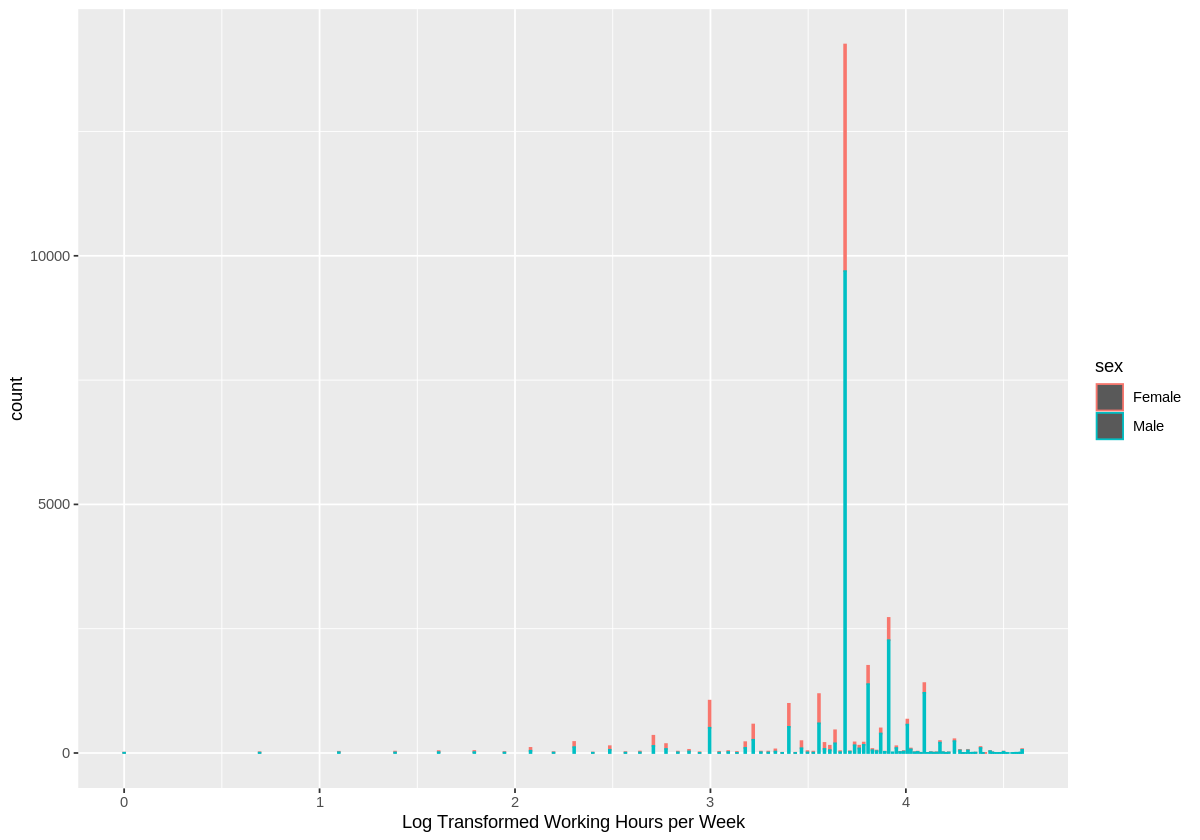

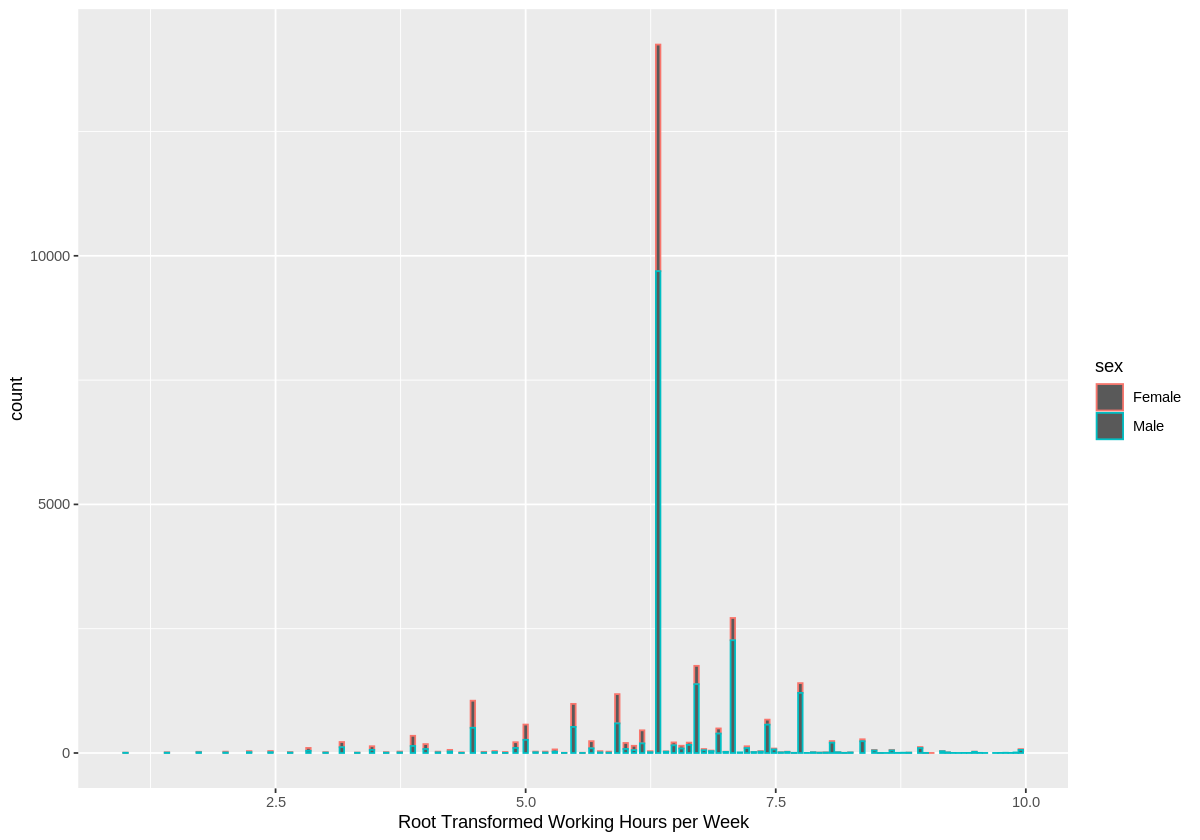

In [44]:
set.seed(795)
log_adult <- noques_adult %>%
mutate(hours.per.week = log(hours.per.week))

root_adult <- noques_adult %>%
mutate(hours.per.week = sqrt(hours.per.week))

head(log_adult)
head(root_adult)

skewness(noques_adult %>% select(hours.per.week))
skewness(log_adult %>% select(hours.per.week))
skewness(root_adult %>% select(hours.per.week))

options(repr.plot.width = 10, repr.plot.height = 7)
og_hours_sex_plot <- noques_adult %>% ggplot(aes(x = hours.per.week)) + geom_bar(aes(colour = sex)) + xlab("Working Hours per Week")
og_hours_sex_plot

options(repr.plot.width = 10, repr.plot.height = 7)
log_hours_sex_plot <- log_adult %>% ggplot(aes(x = hours.per.week)) + geom_bar(aes(colour = sex)) + xlab("Log Transformed Working Hours per Week")
log_hours_sex_plot

options(repr.plot.width = 10, repr.plot.height = 7)
root_hours_sex_plot <- root_adult %>% ggplot(aes(x = hours.per.week)) + geom_bar(aes(colour = sex)) + xlab("Root Transformed Working Hours per Week")
root_hours_sex_plot



In [ ]:
noques_adult <- noques_adult %>% mutate(capital.net = ifelse(capital.loss > 0, -1 * capital.loss, capital.gain)) %>%
                                    select(- capital.loss, - capital.gain)
head(noques_adult)
nrow(noques_adult %>% select(capital.net) %>% filter(capital.net == 0))
noques_adult <- noques_adult %>% select(- capital.net)
head(noques_adult)

In [45]:
set.seed(795)
noques_adult$ID <- rownames(noques_adult)

adult_train <- 
    noques_adult %>% 
    slice_sample(prop = 0.7)

adult_test <- 
    noques_adult %>% 
    anti_join(adult_train, by = "ID")

adult_train <- adult_train  %>% select(-ID)
adult_test <- adult_test  %>% select(-ID)
head(adult_train)
head(adult_test)
noques_adult <- noques_adult %>% select(-ID)

age,workclass,fnlwgt,education,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
21,Private,109952,=HighSchool,Married,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
38,Private,227945,HighUpper,Married,Prof-specialty,Husband,White,Male,99999,0,65,United-States,>50K
44,State-gov,87282,LowUpper,Married,Prof-specialty,Not-in-family,Asian-Pac-Islander,Female,0,0,38,United-States,<=50K
27,Private,384308,LowUpper,Married,Craft-repair,Not-in-family,White,Male,0,0,45,United-States,<=50K
19,Private,574271,=HighSchool,Married,Handlers-cleaners,Own-child,White,Male,0,0,28,United-States,<=50K
20,Private,235691,=HighSchool,Married,Sales,Unmarried,White,Male,0,0,40,United-States,<=50K


age,workclass,fnlwgt,education,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
82,Private,132870,=HighSchool,Not Married,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
38,Private,150601,-HighSchool,Not Married,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
52,Private,129177,LowUpper,Not Married,Other-service,Not-in-family,White,Female,0,2824,20,United-States,>50K
34,Private,203034,LowUpper,Not Married,Sales,Not-in-family,White,Male,0,2824,50,United-States,>50K
29,Private,77009,-HighSchool,Not Married,Sales,Not-in-family,White,Female,0,2754,42,United-States,<=50K
61,Private,29059,=HighSchool,Not Married,Sales,Unmarried,White,Female,0,2754,25,United-States,<=50K


In [46]:
adult_forward_sel <- regsubsets(
  x = hours.per.week ~ ., nvmax = 14,
  data = adult_train,
  method = "forward",
)

adult_forward_summary <- summary(adult_forward_sel)
adult_forward_summary

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“1  linear dependencies found”


Reordering variables and trying again:


Subset selection object
Call: regsubsets.formula(x = hours.per.week ~ ., nvmax = 14, data = adult_train, 
    method = "forward", )
40 Variables  (and intercept)
                            Forced in Forced out
age                             FALSE      FALSE
workclassLocal-gov              FALSE      FALSE
workclassPrivate                FALSE      FALSE
workclassSelf-emp-inc           FALSE      FALSE
workclassSelf-emp-not-inc       FALSE      FALSE
workclassState-gov              FALSE      FALSE
fnlwgt                          FALSE      FALSE
education-HighSchool            FALSE      FALSE
education=HighSchool            FALSE      FALSE
educationHighUpper              FALSE      FALSE
educationLowUpper               FALSE      FALSE
marital.statusNot Married       FALSE      FALSE
occupationArmed-Forces          FALSE      FALSE
occupationCraft-repair          FALSE      FALSE
occupationExec-managerial       FALSE      FALSE
occupationFarming-fishing       FALSE      FALSE
occup

In [47]:
adult_forward_summary_df <- tibble(
    n_input_variables = 1:15,
    RSQ = adult_forward_summary$rsq,
    RSS = adult_forward_summary$rss,
    ADJ.R2 = adult_forward_summary$adjr2,
    Cp = adult_forward_summary$cp,
    BIC = adult_forward_summary$bic,
)
adult_forward_summary_df

n_input_variables,RSQ,RSS,ADJ.R2,Cp,BIC
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.07013228,2787225,0.07008821,3015.9819,-1514.547
2,0.11292651,2658952,0.11284242,1908.1659,-2498.847
3,0.13025274,2607018,0.13012907,1460.8312,-2905.150
4,0.14311943,2568451,0.14295697,1129.1494,-3209.714
5,0.14992631,2548047,0.14972484,954.6212,-3368.065
6,0.15628137,2528998,0.15604141,791.8105,-3516.464
7,0.16074669,2515614,0.16046820,678.0078,-3618.489
8,0.16438933,2504695,0.16407242,585.5406,-3700.326
9,0.16810978,2493543,0.16775482,491.0553,-3784.537


In [48]:
adult_OLS_add <- lm(hours.per.week ~ .,
  adult_train
)
adult_OLS_add


Call:
lm(formula = hours.per.week ~ ., data = adult_train)

Coefficients:
                (Intercept)                          age  
                  4.111e+01                   -9.204e-02  
         workclassLocal-gov             workclassPrivate  
                 -2.302e-02                    2.322e-01  
      workclassSelf-emp-inc    workclassSelf-emp-not-inc  
                  5.216e+00                    1.936e+00  
         workclassState-gov                       fnlwgt  
                 -2.000e+00                   -2.242e-06  
       education-HighSchool         education=HighSchool  
                 -4.325e-02                    2.444e+00  
         educationHighUpper            educationLowUpper  
                  4.291e+00                    2.191e+00  
  marital.statusNot Married       occupationArmed-Forces  
                  2.329e+00                    7.452e-01  
     occupationCraft-repair    occupationExec-managerial  
                  1.500e+00             

In [49]:
adult_test_pred_full_OLS_add <- predict(adult_OLS_add, newdata = adult_test)
head(adult_test_pred_full_OLS_add)

1        2        3        4        5        6 
40.51216 40.80426 39.15869 47.17327 40.05481 39.39536

In [50]:
adult_R_MSE_models <- tibble(
  Model = "OLS Full Regression",
  R_MSE = rmse(
    preds = adult_test_pred_full_OLS_add,
    actuals = adult_test$hours.per.week
  )
)
adult_R_MSE_models

Model,R_MSE
<chr>,<dbl>
OLS Full Regression,10.98814


In [51]:
set.seed(795)
adult_s <- sample_n(noques_adult, 100, replace = FALSE)

adult_s_OLS_add <- lm(hours.per.week ~ .,
  adult_s
)

adult_pi <- adult_s  %>%  
    cbind(predict(adult_s_OLS_add, interval="prediction"))
adult_pi

Warning message in predict.lm(adult_s_OLS_add, interval = "prediction"):
“predictions on current data refer to _future_ responses
”


,age,workclass,fnlwgt,education,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,fit,lwr,upr
,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
1,21,Private,109952,=HighSchool,Married,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K,48.59877,30.95723,66.24031
2,38,Private,227945,HighUpper,Married,Prof-specialty,Husband,White,Male,99999,0,65,United-States,>50K,62.79628,39.79936,85.79320
3,44,State-gov,87282,LowUpper,Married,Prof-specialty,Not-in-family,Asian-Pac-Islander,Female,0,0,38,United-States,<=50K,34.98248,14.90605,55.05891
4,27,Private,384308,LowUpper,Married,Craft-repair,Not-in-family,White,Male,0,0,45,United-States,<=50K,46.56775,28.05007,65.08543
5,19,Private,574271,=HighSchool,Married,Handlers-cleaners,Own-child,White,Male,0,0,28,United-States,<=50K,30.25369,10.47309,50.03428
6,20,Private,235691,=HighSchool,Married,Sales,Unmarried,White,Male,0,0,40,United-States,<=50K,39.69220,21.31239,58.07202
7,25,Private,19214,=HighSchool,Married,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,37.93986,18.65034,57.22937
8,59,Self-emp-not-inc,188003,LowUpper,Not Married,Prof-specialty,Not-in-family,White,Female,0,0,50,United-States,>50K,38.51109,20.10367,56.91851
9,69,Private,108196,-HighSchool,Married,Craft-repair,Other-relative,White,Male,0,0,40,United-States,<=50K,35.76855,14.26920,57.26790


**Discussion**

**References**

Kohavi, R. & Becker, B. (1994). Adult Census Income [census report] Retrieved July 21, 2022, from Kaggle. https://www.kaggle.com/datasets/uciml/adult-census-income?search=cite <br>
Dunga, S. H. (2017). a gender and marital status analysis of household income in a low-income township. Studia Universitatis Babeș-Bolyai. Oeconomica, 62(1), 20-30. https://doi.org/10.1515/subboec-2017-0002 <br>
Messenger, J.C., Lee, S. & McCann, D. (2007). Working Time Around the World: Trends in Working Hours, Laws and Policies in a Global Comparative Perspective. Routledge. https://doi.org/10.4324/9780203945216 <br>
Clawson, D. & Gerstel, N. (2014). Unequal Time: Gender, Class and Family in Employment Schedules. Russell Sage Foundation. 